# Metodo de proyeccion de gradiente en el entrenamiento de Support Vector Machines

### Juan Sanchez, David Halliday, David Molina, Christian Pabon
### Universidad Nacional de Colombia - 28 de Junio del 2022

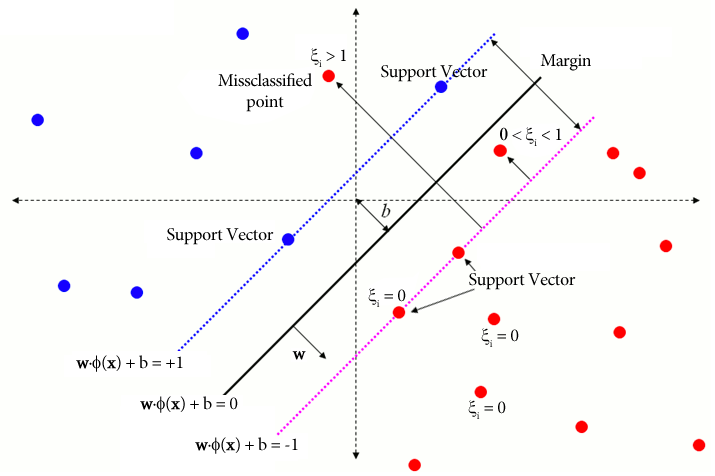

## Librerías

In [60]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.utils import shuffle 
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
from sklearn import datasets, metrics, model_selection, svm

import liboptpy.base_optimizer as base
import liboptpy.constr_solvers as cs
import liboptpy.step_size as ss
import liboptpy.unconstr_solvers as solvers

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

import cvxopt
import time

In [2]:
pwd #Path Archivo

'/home/demolinar/my_project_dir/Metodo-de-proyeccion-de-gradiente-en-el-entrenamiento-de-Support-Vector-Machines'

In [6]:
print(os.listdir("/home/demolinar/my_project_dir/Metodo-de-proyeccion-de-gradiente-en-el-entrenamiento-de-Support-Vector-Machines/Fruit-Images-Dataset"))   
path_t = "/home/demolinar/my_project_dir/Metodo-de-proyeccion-de-gradiente-en-el-entrenamiento-de-Support-Vector-Machines/Fruit-Images-Dataset/"
dim = 100

['Training', 'Test']


In [45]:
def getYourFruits(fruits, data_type, print_n=False, k_fold=False): #Función que recibe qué tipos de frutas devolver, y el nombre que se le asigna al path
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold: 
        path = path_t + data_type + "/" #Sobre el path del usuario, se le agrega si es training o test, y es en esta carpeta que va a ir lo siguiente
        print(path)
        for i,f in enumerate(fruits): #Recorremos por cada una de las frutas dadas como parámetro
            p = path + f
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")): #Acá, por cada imagen de tal fruta vamos a obtener la imagen con cv2
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim)) #La obtenemos a escala
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #Con el formato adecuado
                images.append(image) #La agregamos al conjunto de las imágenes, que devolveremos
                labels.append(i) #Agregamos su respectiva etiqueta
                j+=1 #Llevamos un contador de la cantidad de elementos de este tipo de fruta.
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels #Devolvemos dos arreglos, uno de las imágenes y otro en el que estén sus respectivas etiquetas
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob(path_t + "Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits

In [114]:
#Escogemos las frutas que vamos a utilizar
fruits = ['Banana' , 'Avocado'] #Utilizamos la clasificación binaria con estos dos valores 
X_t, y_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False) #Obtenemos las imágenes y sus etiquetas para el conjunto de entrenamiento
X_test, y_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False) #Ahora los mismos pero para el conjunto de comprobación

#Pasar las imágenes a escala
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t]) #Para las imágenes del conjunto de entrenamiento
X_test = scaler.fit_transform([i.flatten() for i in X_test])#Para las del conjunto de comprobación


/home/demolinar/my_project_dir/Metodo-de-proyeccion-de-gradiente-en-el-entrenamiento-de-Support-Vector-Machines/Fruit-Images-Dataset/Training/
There are  490   TRAINING  images of  BANANA
There are  427   TRAINING  images of  AVOCADO
/home/demolinar/my_project_dir/Metodo-de-proyeccion-de-gradiente-en-el-entrenamiento-de-Support-Vector-Machines/Fruit-Images-Dataset/Test/
There are  166   TEST  images of  BANANA
There are  143   TEST  images of  AVOCADO


In [8]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)): #Función para plottear un conjunto de imágenes dado, dependiendo de cuántas querramos por filas y columnas
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n]) #Agrega la n-ésima imagen
            n += 1   

Banana


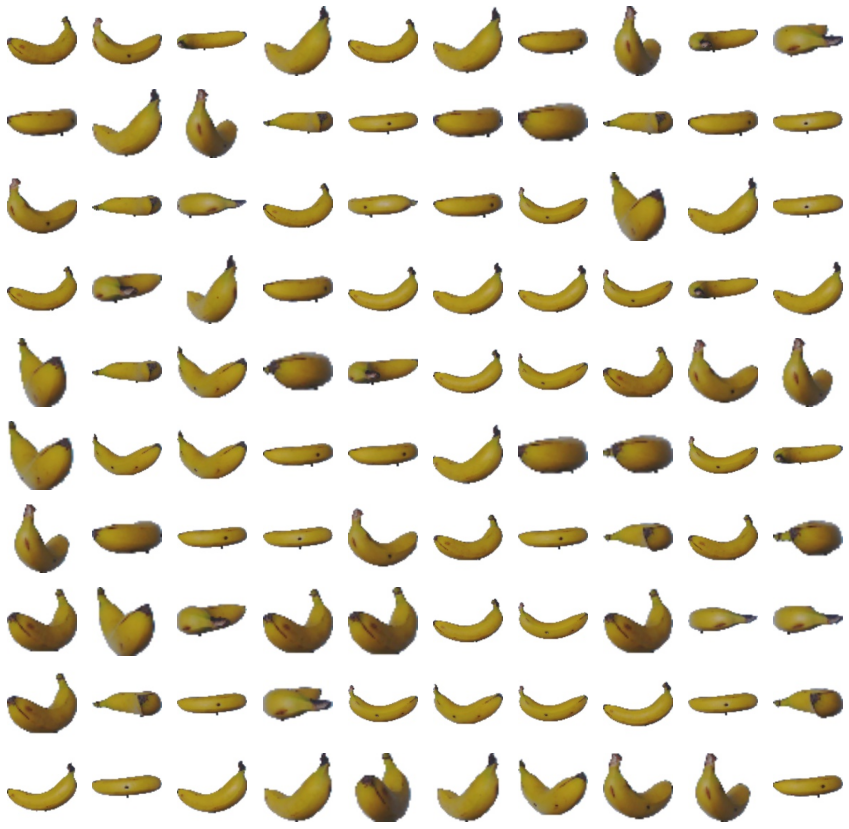

In [9]:
print(fruits[y_train[0]]) #Veamos entonces cómo queda si graficamos los bananos
plot_image_grid(X_t[0:100], 10, 10)

Avocado


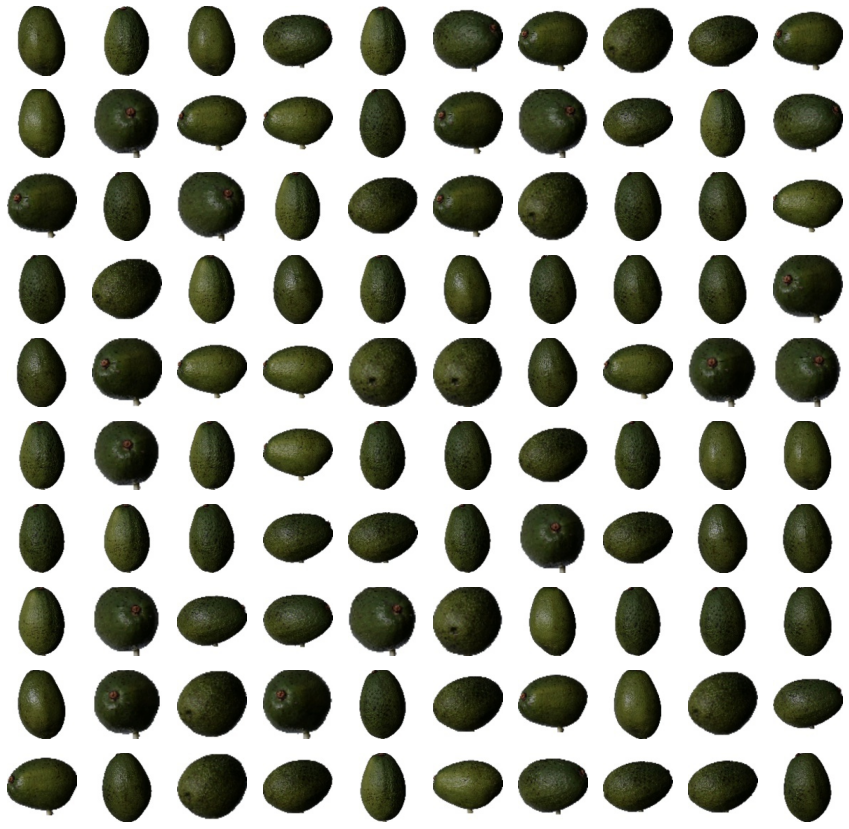

In [10]:
print(fruits[y_train[490]]) #Ahora los aguacates
plot_image_grid(X_t[490:590], 10, 10)

## Análisis de Componentes Principales (PCA) 

In [47]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X, dim): #Función para plottear los datos en dim dimensiones, puede ser 2 o 3
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd'] #tipos de figuras que se pueden utilizar para significar un objeto
    tot = len(X)
    start = 0 
    if(dim == 2): #Caso de dos dimensiones
        for i,index in enumerate(v): #Para cada tipo de fruta en el conjunto de datos de entrenamiento
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i]) #Plottea todos los elementos
            start = end                                                           #Que tienen en común una etiqueta con el mismo color y fijura, en dos dimensiones
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3): #Caso de tres dimensiones
        fig = plt.figure()
        fig.set_size_inches(15, 15)
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end      #Se realiza un proceso similar pero para tres dimensiones
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y plottea la matriz de confusión.
    Si se desea normalizar, establezca normalize=True.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Calcula la matriz de confusión
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Utilizando únicamente las etiquedas dadas en nuestro contexto
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... y se etiquetan con sus respectivas entradas de las listas
           xticklabels=fruits, yticklabels=fruits,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Alineamos y enderezamos las ticklabels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Realizamos un ciclo en la dimensión de los datos y agregamos la información
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

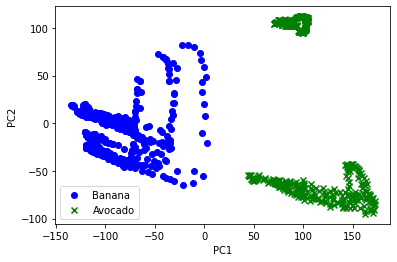

In [48]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn2D, 2) #Muestra del plotteo de esta información con dos dimensiones

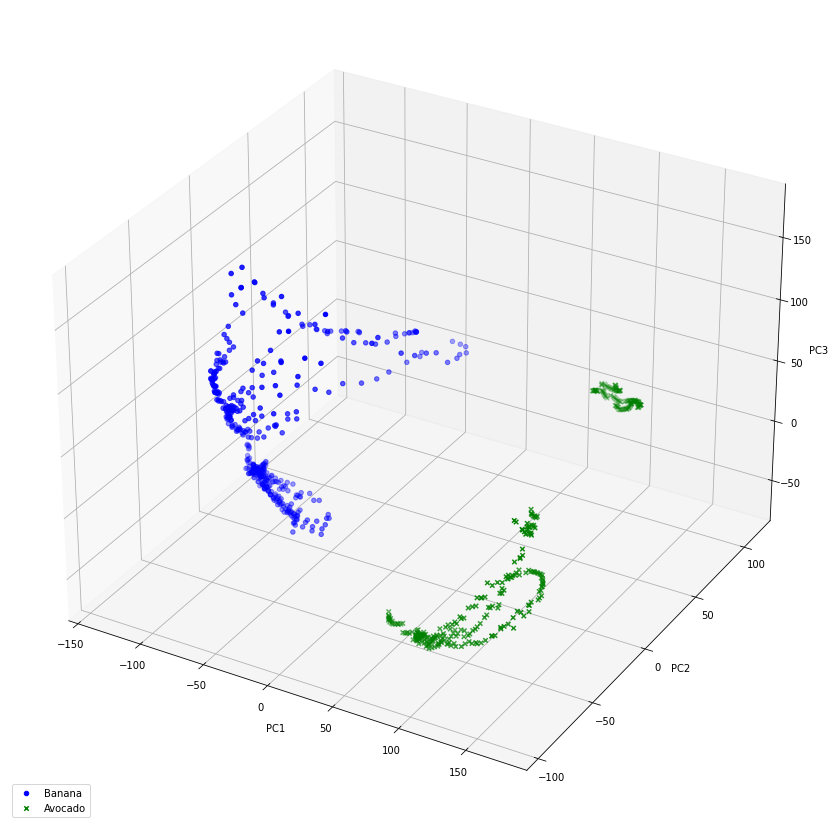

In [49]:
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn3D, 3) #Muestra con tres dimensiones

In [50]:
def showPCA(image,X2, X10, X50): #Función para mostrar las diferencias entre la misma imagen si le disminuimos su dimensión
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Imagen Original')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('50 PC')
    plt.imshow(X50)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('10 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('2 PC')
    plt.imshow(X2)
    plt.show()
    
def showVariance(X_train): #Función que plottea la varianza acumulada a comparación con la individual
    #Calcule manualmente los componentes principales
    cov_matr=np.dot(X_train, X_train.T)
    eigval,eigvect=np.linalg.eig(cov_matr)
    index=np.argsort(eigval)[::-1] #Se toman elementos en orden ascendente
    #existe una asociación entre eigvect[:,i] y eigval[i], entonces 
    eigvect=eigvect[:,index]
    eigval=eigval[index]
    n_PC=[]
    var_explained=[]
    var_temp=[]
    var_tmp=0
    for i in range(10):
        var_tmp=var_tmp+eigval[i]
        n_PC.append(i)
        var_temp.append(eigval[i]/(eigval.sum())*100)
        var_explained.append(var_tmp/(eigval.sum())*100)
    fig, ax = plt.subplots(figsize=(8,8))
    ind = np.arange(10)    
    width = 0.35        
    p1 = ax.bar(ind, var_temp, width, color='b')
    p2 = ax.bar(ind + width, var_explained, width, color='r')
    ax.legend((p1[0], p2[0]), ('Varianza individual explicada', 'Varianza acumulada explicada'))
    ax.set_title('Varianza explicada con PCA')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
    plt.xlabel('Grado de PCA')
    plt.ylabel('Varianza explicada porcentual %')
    ax.autoscale_view()
    plt.show()
    
def computePCA(n, im_scaled, image_id): #Función que realiza el PCA sobre una imagen dada escalada
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled)
    im_reduced = pca.inverse_transform(principalComponents)
    newImage = scaler.inverse_transform([im_reduced[image_id]])
    return newImage

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


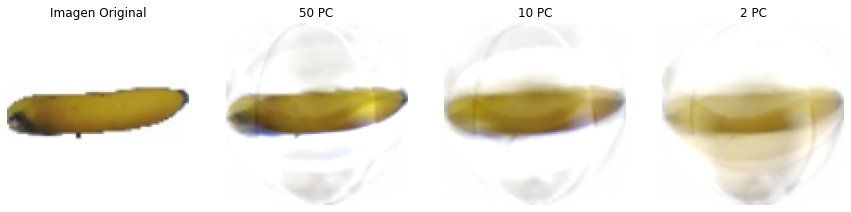

In [15]:
image_id = 2 #Realicemos un ejemplo sobre la segunda imagen del conjunto de imágenes de entrenamiento para comparar cómo cambia según el PCA bajando su dimensión
image = X_t[image_id]
#Compute PCA
X_2 = computePCA(2, X_train,image_id)
X_10 = computePCA(10, X_train,image_id)
X_50 = computePCA(50, X_train,image_id) #Las definimos según qué tanto querramos disminiuir la dimensión
#Reshape in order to plot images
X2 = np.reshape(X_2, (dim,dim,3)).astype(int)
X10 = np.reshape(X_10, (dim,dim,3)).astype(int)
X50 = np.reshape(X_50, (dim,dim,3)).astype(int)
#Plot
showPCA(image, X2, X10, X50) #Ploteamos estas cuatro imágenes

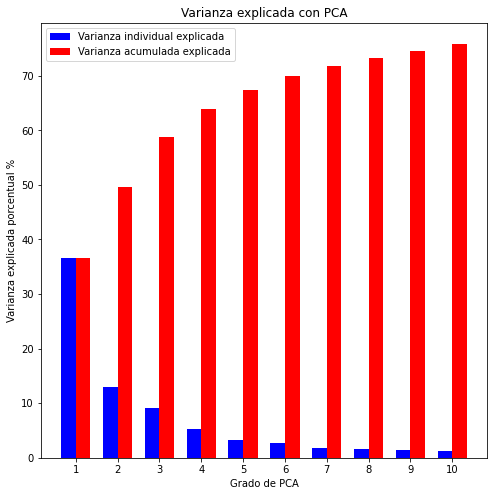

In [16]:
showVariance(X_train) #Ejemplo del uso del plotteo de las varianzas sobre las imágenes de los datos de bananos

## SVM Sklearn

Accuracy with SVM: 100.00%


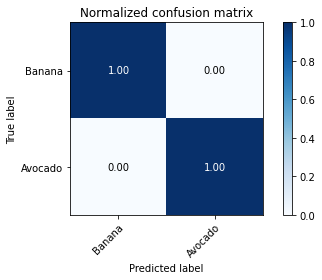

 -------- SVM Sklearn --------- 
--- 13.176594257354736 seconds ---


In [117]:
start_time = time.time()

svm = SVC(gamma='auto', kernel='linear', probability=True) #Definición de la Support Vector Machine de gradiente en descenso con la librería SKLearn
svm.fit(X_train, y_train) #La entrenamos
y_pred = svm.predict(X_test)
#Veamos el proceso de evaluación
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision)) #Imprimimos su porcentaje de Accuracy
cm , _ = plot_confusion_matrix(y_test, y_pred,classes=y_train, normalize=True, title='Normalized confusion matrix') #Plotteamos la matriz de la confusión
plt.show()

# Calculamos los FPR y TPR para todo
probs = svm.predict_proba(X_test)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, probs)
svm_auc = metrics.roc_auc_score(y_test, probs)

print(" -------- SVM Sklearn --------- ")
print("--- %s seconds ---" % (time.time() - start_time))

/home/demolinar/my_project_dir/my_project_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


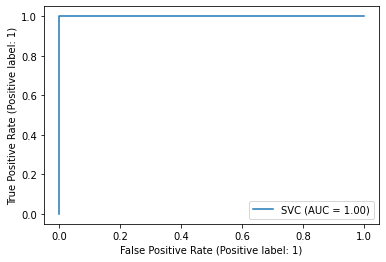

In [66]:
clf = svm.SVC(random_state=0)
clf.fit(X_train, y_train)
metrics.plot_roc_curve(clf, X_test, y_test) 
plt.show()

## SVM Gradiente en Descenso Estocástico

In [41]:
class SVM: #Clase también tomada de https://towardsdatascience.com/support-vector-machine-python-example-d67d9b63f1c8 con el paso a paso incluído}
          # para realizar el aprendizaje por medio del método de gradiente en descenso
    def fit(self, X, y):
        n_samples, n_features = X.shape
        # P = X^T X
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])
        P = cvxopt.matrix(np.outer(y, y) * K)
        # q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        # A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))
        # b = 0 
        b = cvxopt.matrix(0.0)
        # -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        # 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        # Lagrange multipliers
        a = np.ravel(solution['x'])
        # Lagrange have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
            self.b /= len(self.a)
        # Weights
            self.w = np.zeros(n_features)
        for n in range(len(self.a)):
            self.w += self.a[n] * self.sv_y[n] * self.sv[n]
    def project(self, X):
        return np.dot(X, self.w) + self.b
    def predict(self, X):
        return np.sign(self.project(X))

In [227]:
start_time = time.time()

pca = PCA(n_components=2)

X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)
svm = SVM()
y_train[y_train == 0] = -1
tmp = np.ones(len(X_train))
y_train = tmp * y_train
svm.fit(X_train, y_train)

print("SVM Gradiente en Descenso Estocástico")
print("--- %s seconds ---" % (time.time() - start_time))

     pcost       dcost       gap    pres   dres
 0: -7.9736e+01 -1.6024e+02  3e+03  4e+01  2e+00
 1: -1.2604e+02 -1.0122e+02  1e+03  2e+01  8e-01
 2: -1.5585e+02 -1.1925e+02  1e+03  2e+01  8e-01
 3: -1.7360e+02 -8.3296e+01  8e+02  1e+01  5e-01
 4: -1.3223e+02 -3.7214e+01  5e+02  6e+00  3e-01
 5: -2.5961e+01 -1.1838e+00  8e+01  1e+00  5e-02
 6: -3.2800e-01 -1.3900e-03  1e+00  1e-02  6e-04
 7: -3.8029e-03 -1.1905e-03  1e-02  1e-04  6e-06
 8: -7.3918e-04 -1.0760e-03  9e-04  6e-06  3e-07
 9: -8.1349e-04 -9.6604e-04  4e-04  2e-06  1e-07
10: -8.2301e-04 -9.8277e-04  4e-04  2e-06  9e-08
11: -9.2616e-04 -9.5831e-04  4e-05  8e-08  4e-09
12: -9.5331e-04 -9.5416e-04  1e-06  2e-09  8e-11
13: -9.5404e-04 -9.5405e-04  1e-08  2e-11  8e-13
Optimal solution found.
SVM Gradiente en Descenso Estocástico
--- 5.939658880233765 seconds ---


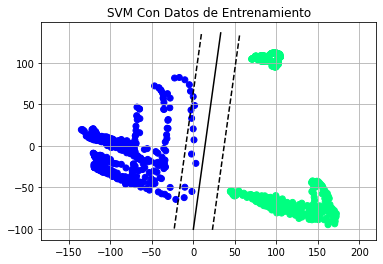

In [76]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')

def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]

# # w.x + b = 0
a0 = 0
a1 = f(a0, svm.w, svm.b)
b0 = 33
b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k')

# # w.x + b = 1
a0 = 23; a1 = f(a0, svm.w, svm.b, 1)
b0 = 56; b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0,b0], [a1,b1], 'k--')

# # w.x + b = -1
a0 = -23; a1 = f(a0, svm.w, svm.b, -1)
b0 = 10; b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--')

plt.axis('equal')
plt.title("SVM Con Datos de Entrenamiento")
plt.grid() #Grafiquemos ahora el separador solución que encontramos optimizando de esa manera mediante una SVM. Utilizando los datos de entrenamiento

In [77]:
svc = LinearSVC()
svc.fit(X_train, y_train)

/home/demolinar/my_project_dir/my_project_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

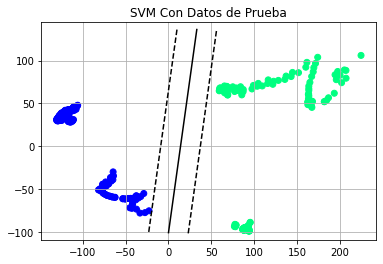

In [78]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='winter');

# # w.x + b = 0
a0 = 0
a1 = f(a0, svm.w, svm.b)
b0 = 33
b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k')

# # w.x + b = 1
a0 = 23; a1 = f(a0, svm.w, svm.b, 1)
b0 = 56; b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0,b0], [a1,b1], 'k--')

# # w.x + b = -1
a0 = -23; a1 = f(a0, svm.w, svm.b, -1)
b0 = 10; b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--')

plt.title("SVM Con Datos de Prueba")
plt.axis('equal')
plt.grid() #Ahora  graficamos los datos de comprobación con el mismo hiperplano de separación, para corroborar.

## SVM Proyección del Gradiente

In [430]:
def func(x, A, b): #Función para resolver el problema cuadrático
    return 0.5 * np.linalg.norm(A.dot(x)-b)**2
f = lambda x: func(x, A, b)
def grad_f(x, A, b):
    grad = -A.T.dot(b)
    grad = grad + A.T.dot(A).dot(x)
    return grad
grad = lambda x: grad_f(x, A, b)

In [431]:
def linsolver(gradient): #Solucionador lineal dado el gradiente
    x = np.zeros(gradient.shape[0])
    pos_grad = gradient > 0
    neg_grad = gradient < 0
    x[pos_grad] = np.zeros(np.sum(pos_grad == True))
    x[neg_grad] = np.ones(np.sum(neg_grad == True))
    return x

In [432]:
def projection(y): #Restringimos según las condiciones de minimización
    return np.clip(y, 0, 1)

In [433]:
n = X_train.shape[1]
m = X_train.shape[0]
A = X_train
b = y_train
methods = {"PGD": cs.ProjectedGD(f, grad, projection, ss.Backtracking(rule_type="Armijo", rho=0.05, beta=0.1, init_alpha=1.))}  

In [436]:
x0 = np.random.randn(n)
max_iter = 100
tol = 1e-5

In [437]:
start_time = time.time()
for m_name in methods:
    print("\t", m_name)
    x = methods[m_name].solve(x0=x0, max_iter=max_iter, tol=tol, disp=1)
print("--- %s seconds ---" % (time.time() - start_time))

	 PGD
Required tolerance achieved!
Convergence in 59 iterations
Function value = 42.03229912934926
Difference in function values = 7.6278069727209186e-06
Difference in argument = 3.592280897030866e-07
--- 0.05489540100097656 seconds ---
